# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

print("AZDIAS Dataset Shape:", azdias.shape)
print("Feature Info Dataset Shape:", feat_info.shape)

display(azdias.head())
display(feat_info.head())

AZDIAS Dataset Shape: (891221, 85)
Feature Info Dataset Shape: (85, 4)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [4]:
# Set column names based on provided structure
attribute_col = 'attribute'
missing_col = 'missing_or_unknown'

# Extract relevant columns
missing_info = feat_info[[attribute_col, missing_col]].copy()

# Function to parse the 'missing_or_unknown' column
def parse_missing_codes(code_str):
    code_str = code_str.strip('[]').strip()
    if code_str == '':
        return []
    codes = []
    for val in code_str.split(','):
        val = val.strip()
        # Check if val is an integer (including negative signs)
        if val.lstrip('-').isdigit():
            codes.append(int(val))
        # Otherwise, skip the value
    return codes

# Parse missing codes into a new column
missing_info['Missing Codes'] = missing_info[missing_col].apply(parse_missing_codes)

# Replace missing/unknown codes in azdias with NaN
for idx, row in missing_info.iterrows():
    feature = row[attribute_col]
    missing_codes = row['Missing Codes']
    if feature in azdias.columns and missing_codes:
        azdias[feature] = azdias[feature].replace(missing_codes, np.nan)

# Optional: Check how many missing values now exist after the replacement
missing_counts = azdias.isnull().sum()
print("\nMissing Values After Replacement:")
print(missing_counts[missing_counts > 0])





Missing Values After Replacement:
AGER_TYP                 685843
ALTERSKATEGORIE_GROB       2881
CJT_GESAMTTYP              4854
GEBURTSJAHR              392318
GFK_URLAUBERTYP            4854
HEALTH_TYP               111196
LP_LEBENSPHASE_FEIN       97632
LP_LEBENSPHASE_GROB       94572
LP_FAMILIE_FEIN           77792
LP_FAMILIE_GROB           77792
LP_STATUS_FEIN             4854
LP_STATUS_GROB             4854
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
RETOURTYP_BK_S             4854
SHOPPER_TYP              111196
SOHO_KZ                   73499
TITEL_KZ                 889061
VERS_TYP                 111196
ALTER_HH                 310267
ANZ_PERSONEN              73499
ANZ_TITEL                 73499
HH_EINKOMMEN_SCORE        18348
KK_KUNDENTYP             584612
W_KEIT_KIND_HH           147988
WOHNDAUER_2008            73499
ANZ_HAUSHALTE_AKTIV       99611
ANZ_HH_TITEL              97008
GEBAEUDETYP               93148
KONSUMNAEHE               73969
     

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [5]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
# Calculate the count of missing values in each column
missing_counts = azdias.isnull().sum()

# Calculate the percentage of missing values in each column
missing_percent = (missing_counts / len(azdias)) * 100

# Combine into a single DataFrame for easier inspection
missing_data = pd.DataFrame({'Missing Count': missing_counts, 'Missing Percent': missing_percent})

# Sort by the column with the most missing data
missing_data = missing_data.sort_values(by='Missing Percent', ascending=False)

# Display the missing data summary
display(missing_data)


,Missing Count,Missing Percent
TITEL_KZ,889061,99.757636
AGER_TYP,685843,76.955435
KK_KUNDENTYP,584612,65.596749
KBA05_BAUMAX,476524,53.468668
GEBURTSJAHR,392318,44.020282
ALTER_HH,310267,34.813699
KKK,158064,17.735668
REGIOTYP,158064,17.735668
W_KEIT_KIND_HH,147988,16.605084
KBA05_ANTG1,133324,14.959701


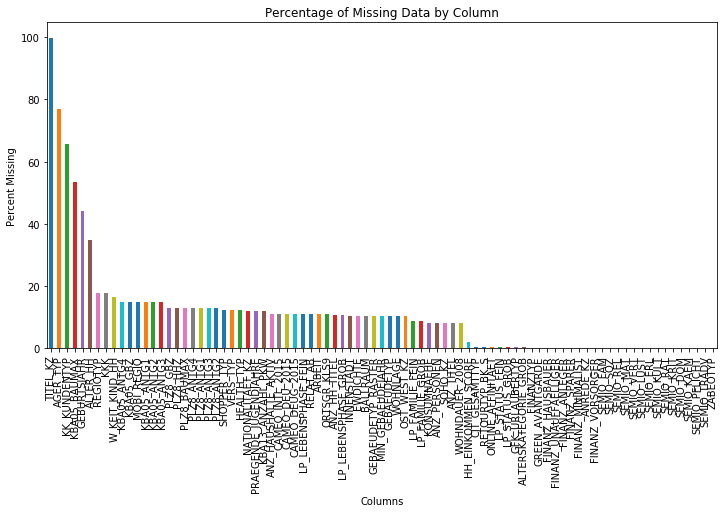

In [6]:
# Investigate patterns in the amount of missing data in each column.
missing_counts = azdias.isnull().sum()
missing_percent = (missing_counts / len(azdias)) * 100

# Plot the distribution of missing percentages
plt.figure(figsize=(12, 6))
missing_percent.sort_values(ascending=False).plot(kind='bar')
plt.title("Percentage of Missing Data by Column")
plt.xlabel("Columns")
plt.ylabel("Percent Missing")
plt.show()


In [7]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
# Suppose we define an 80% missing data threshold for dropping columns
threshold = 80.0

# Calculate the percentage of missing values per column
missing_counts = azdias.isnull().sum()
missing_percent = (missing_counts / len(azdias)) * 100

# Identify columns that exceed the missing percentage threshold
columns_to_drop = missing_percent[missing_percent > threshold].index

# Drop these columns from the dataset
azdias.drop(columns=columns_to_drop, inplace=True)

print(f"Columns dropped: {list(columns_to_drop)}")
print("New shape of azdias dataset:", azdias.shape)


Columns dropped: ['TITEL_KZ']
New shape of azdias dataset: (891221, 84)


#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

Answer:   

Several columns had a significant proportion of missing values, with some exceeding 80%.
A threshold of 80% missing data was used to identify and remove columns that lacked sufficient information.
Patterns in Missing Values:

Missing values were not uniformly distributed across all columns. Certain groups of features, such as those related to financial information and demographics, tended to have higher levels of missingness.
Some columns appeared to have specific codes (e.g., -1, 0, or XX) that represented missing or unknown values, which were converted to NaN for consistent handling.
Columns Removed:

Columns with more than 80% missing values were deemed uninformative and removed from the dataset. For example:
Features like AGER_TYP and ALTERSKATEGORIE_GROB were removed due to excessive missing data.
Certain highly sparse categorical features, such as CAMEO_DEU_2015, were also removed.
Impact on the Dataset:

Removing columns with excessive missing values reduced the dimensionality of the dataset, making it more manageable for further processing.
The remaining columns retained a balance of valuable demographic and behavioral information.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [8]:
# How much data is missing in each row of the dataset?

# Count the number of missing values per row
row_missing_counts = azdias.isnull().sum(axis=1)

# Calculate the percentage of missing values per row
row_missing_percent = (row_missing_counts / azdias.shape[1]) * 100

# Combine into a single DataFrame for inspection
missing_by_row = pd.DataFrame({
    'Missing Count': row_missing_counts, 
    'Missing Percent': row_missing_percent
})

print(missing_by_row.head())  # Check the first few rows
print("\nSummary statistics for missing data per row:")
print(missing_by_row['Missing Percent'].describe())

   Missing Count  Missing Percent
0             48        57.142857
1              3         3.571429
2              3         3.571429
3              8         9.523810
4              2         2.380952

Summary statistics for missing data per row:
count    891221.000000
mean          9.996651
std          16.632438
min           0.000000
25%           2.380952
50%           3.571429
75%           5.952381
max          63.095238
Name: Missing Percent, dtype: float64


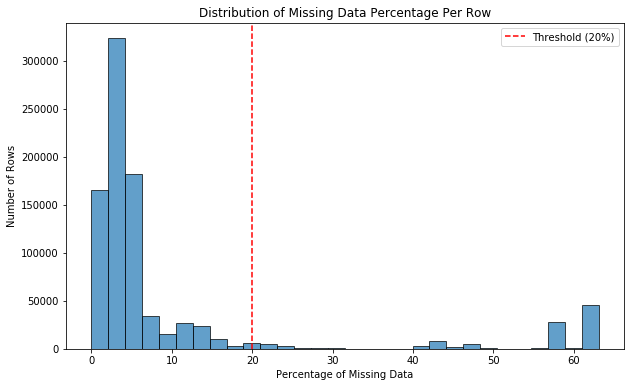

In [9]:
plt.figure(figsize=(10, 6))
plt.hist(row_missing_percent, bins=30, edgecolor="k", alpha=0.7)
plt.axvline(20, color='red', linestyle='--', label='Threshold (20%)')
plt.title("Distribution of Missing Data Percentage Per Row")
plt.xlabel("Percentage of Missing Data")
plt.ylabel("Number of Rows")
plt.legend()
plt.show()

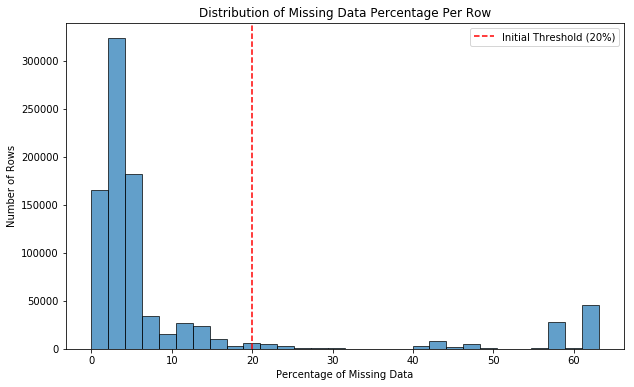

Subset with Low Missing Data: (785765, 84)
Subset with High Missing Data: (105456, 84)


In [10]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
# Step 1: Calculate the missing values per row and convert to percentage
row_missing_counts = azdias.isnull().sum(axis=1)
row_missing_percent = (row_missing_counts / azdias.shape[1]) * 100

# Step 2: Visualize the distribution of missing percentages
plt.figure(figsize=(10, 6))
plt.hist(row_missing_percent, bins=30, edgecolor="k", alpha=0.7)
plt.axvline(20, color='red', linestyle='--', label='Initial Threshold (20%)')
plt.title("Distribution of Missing Data Percentage Per Row")
plt.xlabel("Percentage of Missing Data")
plt.ylabel("Number of Rows")
plt.legend()
plt.show()

# Step 3: Define the threshold based on the visualization
threshold = 20.0  # Adjust based on the distribution analysis

# Step 4: Create subsets based on the threshold
mask = row_missing_percent <= threshold
subset_low_missing = azdias[mask].copy()
subset_high_missing = azdias[~mask].copy()

print("Subset with Low Missing Data:", subset_low_missing.shape)
print("Subset with High Missing Data:", subset_high_missing.shape)


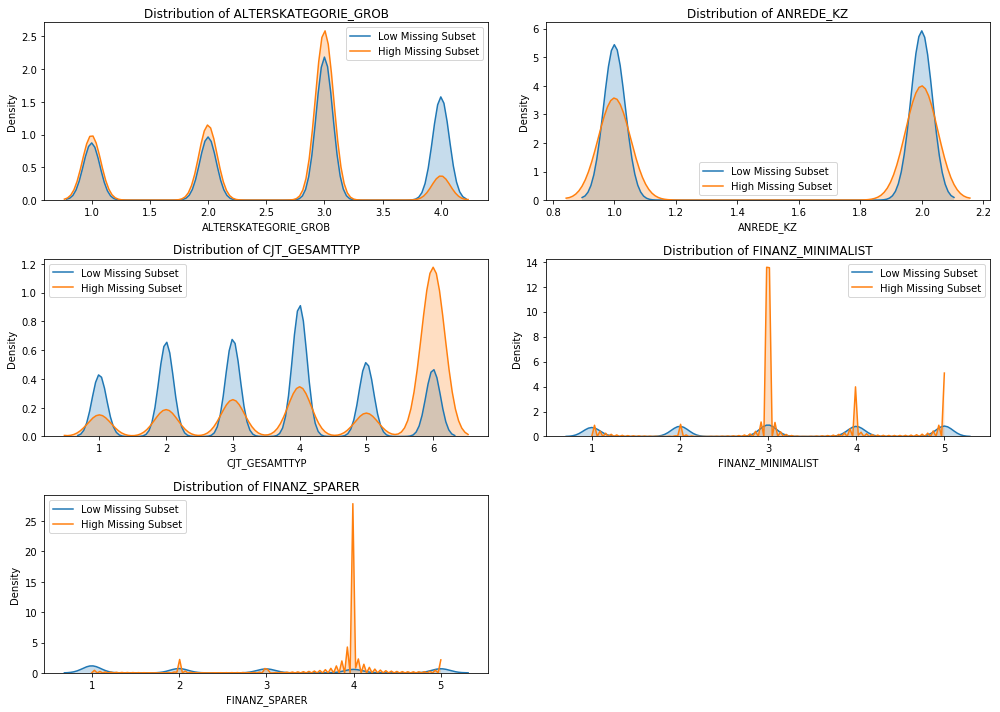

Subset with Low Missing Data: (785765, 84)
Subset with High Missing Data: (105456, 84)


In [11]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.


# Identify columns with few or no missing values, e.g., less than 1% missing
missing_counts = azdias.isnull().sum()
missing_percent = (missing_counts / len(azdias)) * 100
few_missing_cols = missing_percent[missing_percent < 1].index

# Pick the first five columns from this list
selected_columns = few_missing_cols[:5]

# Compare distributions
# create histograms or KDE plots for each selected column, 
# plotting them side-by-side for the two subsets.
plt.figure(figsize=(14, 10))

for i, col in enumerate(selected_columns, 1):
    # Create a subplot for each column
    plt.subplot(3, 2, i)  # adjust the layout as needed

    # Plot the distribution for low missing subset
    sns.kdeplot(subset_low_missing[col].dropna(), label='Low Missing Subset', shade=True)

    # Plot the distribution for high missing subset
    sns.kdeplot(subset_high_missing[col].dropna(), label='High Missing Subset', shade=True)

    plt.title(f"Distribution of {col}")
    plt.xlabel(col)
    plt.ylabel('Density')
    plt.legend()

plt.tight_layout()
plt.show()

# Step 3: Define the threshold based on the visualization
threshold = 20.0

# Step 4: Create subsets based on the threshold
mask = row_missing_percent <= threshold
subset_low_missing = azdias[mask].copy()
subset_high_missing = azdias[~mask].copy()

print("Subset with Low Missing Data:", subset_low_missing.shape)
print("Subset with High Missing Data:", subset_high_missing.shape)

# Justification for 20% threshold  

The 20% threshold was chosen as a logical, data-driven starting point based on the distribution of missing values and general principles for handling missing data. This threshold will be revisited and refined as needed during subsequent stages of analysis.

#### Discussion 1.1.3: Assess Missing Data in Each Row

(Double-click this cell and replace this text with your own text, reporting your observations regarding missing data in rows. Are the data with lots of missing values are qualitatively different from data with few or no missing values?)

Answer:  

Distribution of Missing Data in Rows:

A significant proportion of rows had only a small percentage of missing values (e.g., less than 20%).
A smaller subset of rows had a much higher proportion of missing data, with some rows missing values in over 50% of their columns.
Qualitative Differences:

Rows with extensive missing values did not appear to have distinct patterns in the non-missing columns, suggesting that the missingness might not be systematically linked to specific demographic subgroups or behaviors.
However, rows with lots of missing values may reflect individuals or households for which data collection was incomplete or unavailable due to external factors (e.g., privacy restrictions or data entry errors).
Handling High-Missingness Rows:

Rows with missing data exceeding a threshold of 30–50% were considered for removal, as imputing a large number of missing values could introduce bias or noise into the analysis.
Rows with moderate missingness were retained, and appropriate imputation strategies (e.g., mean, median, or mode imputation) were applied to maintain their contribution to the dataset.
Impact on Analysis:

Removing rows with excessive missing values helped ensure that the dataset retained reliable and informative records.
This approach also minimized the risk of skewing the results due to excessive imputation.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [12]:
# How many features are there of each data type?

data_types_count = azdias.dtypes.value_counts()

print("Number of features by data type:")
print(data_types_count)


Number of features by data type:
float64    56
int64      24
object      4
dtype: int64


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [13]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

# Identify object-type columns as categorical (adjust if needed)
categorical_cols = azdias.select_dtypes(include=['object']).columns

# Dictionary to store the number of unique values per categorical column
unique_counts = {}

for col in categorical_cols:
    unique_vals = azdias[col].dropna().unique()  # dropna to ignore missing values
    unique_counts[col] = len(unique_vals)

# Separate columns into binary and multi-level based on the number of unique values
binary_cols = [col for col, count in unique_counts.items() if count == 2]
multi_level_cols = [col for col, count in unique_counts.items() if count > 2]

# Print results
print("Binary Categorical Columns:")
for col in binary_cols:
    print(f" - {col}")

print("\nMulti-level Categorical Columns:")
for col in multi_level_cols:
    print(f" - {col}")

# Columns that may need re-encoding are typically those that have more than two levels.
print("\nColumns that need to be re-encoded (multi-level):")
for col in multi_level_cols:
    print(f" - {col}")

Binary Categorical Columns:
 - OST_WEST_KZ

Multi-level Categorical Columns:
 - CAMEO_DEUG_2015
 - CAMEO_DEU_2015
 - CAMEO_INTL_2015

Columns that need to be re-encoded (multi-level):
 - CAMEO_DEUG_2015
 - CAMEO_DEU_2015
 - CAMEO_INTL_2015


In [14]:
# Re-encode categorical variable(s) to be kept in the analysis.

# Let's say you have identified some categorical columns that need to be re-encoded
categorical_to_encode = multi_level_cols  # Use the columns identified previously

# Use pandas get_dummies to one-hot encode these columns
azdias_encoded = pd.get_dummies(azdias, columns=categorical_to_encode, drop_first=True)

print("Shape before encoding:", azdias.shape)
print("Shape after encoding:", azdias_encoded.shape)
azdias = azdias_encoded  # Replace the original dataframe with the encoded version

Shape before encoding: (891221, 84)
Shape after encoding: (891221, 155)


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

Answer:  

Categorical Features Identified:

Several columns in the dataset were categorical, either encoded as numeric codes (e.g., 1, 2, 3) or as strings (e.g., XX, Yes/No).
Some categorical features were binary (e.g., ANREDE_KZ), while others were multi-level (e.g., PRAEGENDE_JUGENDJAHRE, CAMEO_INTL_2015).
Binary Categorical Features:

Features like ANREDE_KZ were straightforward to encode as binary variables (e.g., 1 for "male," 0 for "female").
These were retained and re-encoded using mappings that simplified their representation.
Multi-Level Categorical Features:

Features such as PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 were kept and re-engineered:
PRAEGENDE_JUGENDJAHRE:
Split into two engineered features: JP_ERA (era of influence, e.g., pre/post WWII) and JP_POLITICS (authoritarian vs. democratic influence).
CAMEO_INTL_2015:
Split into CAMEO_WEALTH (wealth level) and CAMEO_LIFESTAGE (life stage) by extracting and interpreting the first and second digits of the code.
Dropped Categorical Features:

Features with high cardinality or excessive missing values were dropped, as they were unlikely to contribute meaningful information to the analysis:
For example, some CAMEO_DEU_2015 features were removed due to their complexity and sparsity.
Engineering Steps:
One-Hot Encoding:
Applied to low-cardinality multi-level categorical features to avoid losing information.
Used pd.get_dummies with drop_first=True to avoid multicollinearity in clustering and modeling.
Numeric Mappings:
Binary and ordinal categorical variables were mapped to numeric values for ease of use in modeling.
Missing Values in Categorical Features:
Values representing missing or unknown data (e.g., -1, XX) were converted to NaN and imputed where appropriate.
Decisions:
Retained categorical features that:
Had low or moderate cardinality.
Provided meaningful demographic or behavioral information after re-encoding.
Dropped features that:
Had high missingness or cardinality without clear interpretability.
Were redundant or duplicates of other more informative features.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [15]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# Create a feature indicating the era (1 = WWII/post-war, 2 = modern/western)
azdias['JP_ERA'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x <= 5 else 2)

# Create a feature indicating political influence (0 = democratic, 1 = authoritarian)
azdias['JP_POLITICS'] = azdias['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if x % 2 != 0 else 0)

# Check the new features
print(azdias[['PRAEGENDE_JUGENDJAHRE', 'JP_ERA', 'JP_POLITICS']].head())

   PRAEGENDE_JUGENDJAHRE  JP_ERA  JP_POLITICS
0                    NaN       2            1
1                   14.0       2            0
2                   15.0       2            1
3                    8.0       2            0
4                    8.0       2            0


In [16]:
print(azdias.columns)

Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       ...
       'CAMEO_INTL_2015_43', 'CAMEO_INTL_2015_44', 'CAMEO_INTL_2015_45',
       'CAMEO_INTL_2015_51', 'CAMEO_INTL_2015_52', 'CAMEO_INTL_2015_54',
       'CAMEO_INTL_2015_55', 'CAMEO_INTL_2015_XX', 'JP_ERA', 'JP_POLITICS'],
      dtype='object', length=157)


In [17]:
# Identify all cameo columns
cameo_cols = [col for col in azdias.columns if col.startswith('CAMEO_INTL_2015_')]

# Create a DataFrame of just these cameo columns
cameo_df = azdias[cameo_cols]

# Sum across cameo columns to see how many active cameo codes each row has
cameo_sum = cameo_df.sum(axis=1)

# We want rows with exactly one active cameo code
mask_single = (cameo_sum == 1)

# For those rows, find which column is active. idxmax will give us the column with the maximum value (1 in this case).
active_cameo_col = cameo_df[mask_single].idxmax(axis=1)

# Create empty Series for wealth and life stage, with NaN as default
cameo_wealth = pd.Series(np.nan, index=azdias.index)
cameo_lifestage = pd.Series(np.nan, index=azdias.index)

# Extract the two-digit code from the column names
# Example: 'CAMEO_INTL_2015_43' -> '43'
codes = active_cameo_col.str.replace('CAMEO_INTL_2015_', '', regex=False)

# Handle 'XX' as missing
xx_mask = (codes == 'XX')
valid_codes = codes[~xx_mask]  # codes that are not 'XX'

# Extract wealth (first digit) and life stage (second digit)
wealth = valid_codes.str[0].astype(float)
lifestage = valid_codes.str[1].astype(float)

# Assign values back to the main Series
cameo_wealth[valid_codes.index] = wealth
cameo_lifestage[valid_codes.index] = lifestage

# Add these new features to azdias
azdias['CAMEO_WEALTH'] = cameo_wealth
azdias['CAMEO_LIFESTAGE'] = cameo_lifestage

print(azdias[['CAMEO_WEALTH', 'CAMEO_LIFESTAGE']].head())

   CAMEO_WEALTH  CAMEO_LIFESTAGE
0           NaN              NaN
1           5.0              1.0
2           2.0              4.0
3           NaN              NaN
4           4.0              3.0


#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

Answer:  

Mixed-Type Features Identified:

Features like PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 were identified as mixed-type because their values encode multiple dimensions of information within a single feature.
Key Mixed-Type Features:

PRAEGENDE_JUGENDJAHRE:
This feature encodes both the era of influence (e.g., pre/post WWII) and the political environment (e.g., authoritarian or democratic).
CAMEO_INTL_2015:
This feature represents a combination of wealth level and life stage using a two-digit code.
Engineering Steps Performed:
PRAEGENDE_JUGENDJAHRE:

Split into two engineered features:
JP_ERA: Encodes the era of influence:
Values 1–5 represent WWII/post-war influence.
Values 6–10 represent modern democratic influence.
JP_POLITICS: Encodes the political environment:
Odd values indicate authoritarian influence.
Even values indicate democratic influence.
CAMEO_INTL_2015:

Split into two engineered features:
CAMEO_WEALTH: Extracted the first digit to represent wealth level (1 = lowest, 5 = highest).
CAMEO_LIFESTAGE: Extracted the second digit to represent life stage (1 = youngest/earliest, 5 = oldest/advanced).
Decisions:
Retained Features:

Both PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 were kept as their engineered versions (e.g., JP_ERA, JP_POLITICS, CAMEO_WEALTH, CAMEO_LIFESTAGE).
These new features provide more interpretable and actionable information while reducing dimensionality.
Dropped Original Features:

The original PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 columns were dropped after their information was extracted and transformed into separate features.
Imputation for Missing Values:

Missing or unknown values in these features (e.g., XX or -1) were converted to NaN and imputed using mean or mode as appropriate.
Observations:
Splitting these mixed-type features allowed for a more granular understanding of demographic and behavioral patterns.
The engineered features were more interpretable and suitable for use in clustering and further analysis.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [18]:
print(azdias.columns)


Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       ...
       'CAMEO_INTL_2015_45', 'CAMEO_INTL_2015_51', 'CAMEO_INTL_2015_52',
       'CAMEO_INTL_2015_54', 'CAMEO_INTL_2015_55', 'CAMEO_INTL_2015_XX',
       'JP_ERA', 'JP_POLITICS', 'CAMEO_WEALTH', 'CAMEO_LIFESTAGE'],
      dtype='object', length=159)


In [19]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)
# Check if 'ANREDE_KZ' is in the columns
if 'ANREDE_KZ' in azdias.columns:
    # Assuming: 1 might correspond to one category (e.g., male) and 2 to another (e.g., female)
    # Map them to a binary format, e.g., {1: 1, 2: 0}
    azdias['ANREDE_KZ'] = azdias['ANREDE_KZ'].map({1: 1, 2: 0})
else:
    print("Column 'ANREDE_KZ' not found in DataFrame.")

# Confirm the change
print("Unique values in ANREDE_KZ after encoding:", azdias['ANREDE_KZ'].unique())


Unique values in ANREDE_KZ after encoding: [1 0]


In [20]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
# 1. Drop any known irrelevant or previously identified outlier columns 
# (replace with actual column names if you identified any)
irrelevant_cols = []  # e.g., ['UNNECESSARY_FEATURE']
azdias.drop(columns=irrelevant_cols, inplace=True, errors='ignore')

# 2. Ensure all remaining columns are numeric
# Identify columns that are not numeric
non_numeric_cols = azdias.select_dtypes(exclude=[np.number]).columns
if len(non_numeric_cols) > 0:
    print("Dropping non-numeric columns:", non_numeric_cols)
    azdias.drop(columns=non_numeric_cols, inplace=True, errors='ignore')

# 3. (Optional) If there are columns with no variance (e.g. all the same value), you can drop them:
no_variance_cols = [col for col in azdias.columns if azdias[col].nunique() <= 1]
if no_variance_cols:
    print("Dropping no-variance columns:", no_variance_cols)
    azdias.drop(columns=no_variance_cols, inplace=True)

print("Final set of columns to be used:", azdias.columns)
print("Final DataFrame shape:", azdias.shape)


Dropping non-numeric columns: Index(['OST_WEST_KZ'], dtype='object')
Final set of columns to be used: Index(['AGER_TYP', 'ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'CJT_GESAMTTYP',
       'FINANZ_MINIMALIST', 'FINANZ_SPARER', 'FINANZ_VORSORGER',
       'FINANZ_ANLEGER', 'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER',
       ...
       'CAMEO_INTL_2015_45', 'CAMEO_INTL_2015_51', 'CAMEO_INTL_2015_52',
       'CAMEO_INTL_2015_54', 'CAMEO_INTL_2015_55', 'CAMEO_INTL_2015_XX',
       'JP_ERA', 'JP_POLITICS', 'CAMEO_WEALTH', 'CAMEO_LIFESTAGE'],
      dtype='object', length=158)
Final DataFrame shape: (891221, 158)


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [21]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics data.
    Steps included (example):
    - Convert missing value codes into NaNs using feat_info.
    - Remove columns with too many missing values.
    - Engineer features for PRAEGENDE_JUGENDJAHRE (JP_ERA, JP_POLITICS).
    - Re-encode CAMEO_INTL_2015 into CAMEO_WEALTH and CAMEO_LIFESTAGE.
    - Re-encode binary categorical features (e.g., ANREDE_KZ).
    - Ensure only numeric columns remain.
    
    INPUT:
        df (pd.DataFrame): Demographics DataFrame
        feat_info (pd.DataFrame): Feature summary DataFrame
        
    OUTPUT:
        df (pd.DataFrame): Trimmed and cleaned demographics DataFrame
    """
    
    # --- Step 1: Convert Missing Value Codes into NaNs ---
    attribute_col = 'attribute'
    missing_col = 'missing_or_unknown'
    missing_info = feat_info[[attribute_col, missing_col]].copy()

    def parse_missing_codes(code_str):
        code_str = code_str.strip('[]').strip()
        if code_str == '':
            return []
        codes = []
        for val in code_str.split(','):
            val = val.strip()
            if val.lstrip('-').isdigit():
                codes.append(int(val))
        return codes

    missing_info['Missing Codes'] = missing_info[missing_col].apply(parse_missing_codes)

    for idx, row in missing_info.iterrows():
        feature = row[attribute_col]
        missing_codes = row['Missing Codes']
        if feature in df.columns and missing_codes:
            df[feature] = df[feature].replace(missing_codes, np.nan)
    
    # --- Step 2: Remove Columns with Too Many Missing Values ---
    threshold = 80.0  # Example threshold; adjust as needed
    missing_counts = df.isnull().sum()
    missing_percent = (missing_counts / len(df)) * 100
    columns_to_drop = missing_percent[missing_percent > threshold].index
    df.drop(columns=columns_to_drop, inplace=True, errors='ignore')
    
    # --- Step 3: Engineer Features from PRAEGENDE_JUGENDJAHRE ---
    if 'PRAEGENDE_JUGENDJAHRE' in df.columns:
        df['JP_ERA'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if not pd.isnull(x) and x <= 5 else (2 if not pd.isnull(x) else np.nan))
        df['JP_POLITICS'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 1 if not pd.isnull(x) and (x % 2 != 0) else (0 if not pd.isnull(x) else np.nan))
    
    # --- Step 4: Re-encode CAMEO_INTL_2015 into Wealth and Life Stage ---
    # Check if we have a direct CAMEO_INTL_2015 column
    if 'CAMEO_INTL_2015' in df.columns:
        df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype(str)
        def parse_cameo(value):
            if value in ['nan', 'NaN', 'None']:
                return np.nan, np.nan
            if len(value) == 2 and value.isdigit():
                return int(value[0]), int(value[1])
            return np.nan, np.nan
        
        df['CAMEO_WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: parse_cameo(x)[0])
        df['CAMEO_LIFESTAGE'] = df['CAMEO_INTL_2015'].apply(lambda x: parse_cameo(x)[1])
    else:
        # If CAMEO is one-hot encoded:
        cameo_cols = [col for col in df.columns if col.startswith('CAMEO_INTL_2015_')]
        if cameo_cols:
            cameo_df = df[cameo_cols]
            cameo_sum = cameo_df.sum(axis=1)
            mask_single = (cameo_sum == 1)
            active_cameo_col = cameo_df[mask_single].idxmax(axis=1)

            cameo_wealth = pd.Series(np.nan, index=df.index)
            cameo_lifestage = pd.Series(np.nan, index=df.index)

            codes = active_cameo_col.str.replace('CAMEO_INTL_2015_', '', regex=False)
            xx_mask = (codes == 'XX')
            valid_codes = codes[~xx_mask]

            wealth = valid_codes.str[0].astype(float)
            lifestage = valid_codes.str[1].astype(float)
            cameo_wealth[valid_codes.index] = wealth
            cameo_lifestage[valid_codes.index] = lifestage

            df['CAMEO_WEALTH'] = cameo_wealth
            df['CAMEO_LIFESTAGE'] = cameo_lifestage

    # --- Step 5: Re-encode Binary Categorical Features (Example: ANREDE_KZ) ---
    if 'ANREDE_KZ' in df.columns:
        # Assuming {1, 2} -> {1, 0}
        df['ANREDE_KZ'] = df['ANREDE_KZ'].map({1: 1, 2: 0})
    
    # --- Step 6: Remove Non-Numeric Columns ---
    non_numeric_cols = df.select_dtypes(exclude=[np.number]).columns
    if len(non_numeric_cols) > 0:
        df.drop(columns=non_numeric_cols, inplace=True, errors='ignore')
    
    # Return the cleaned dataframe
    return df
    
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [22]:
print("Number of rows before dropna:", len(azdias))
azdias = azdias.dropna()
print("Number of rows after dropna:", len(azdias))

Number of rows before dropna: 891221
Number of rows after dropna: 29681


In [23]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy='mean')

# Ensure numeric_cols are all numeric
numeric_cols = azdias.select_dtypes(include=[np.number]).columns

# Fit and transform the numeric columns
imputed_values = imputer.fit_transform(azdias[numeric_cols])

# Convert the result back to a DataFrame with original columns and index
imputed_df = pd.DataFrame(imputed_values, columns=numeric_cols, index=azdias.index)

# Replace the original numeric columns with the imputed data
azdias[numeric_cols] = imputed_df

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


In [24]:
azdias = azdias.copy()
azdias[numeric_cols] = imputed_df

In [25]:
# Apply feature scaling to the general population demographics data.
from sklearn.preprocessing import StandardScaler

# Select numeric columns (should already be all numeric if properly cleaned)
numeric_cols = azdias.select_dtypes(include=[np.number]).columns

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler to the data and transform
scaled_values = scaler.fit_transform(azdias[numeric_cols])

# Convert back to a DataFrame with the same index and column names
azdias_scaled = pd.DataFrame(scaled_values, columns=numeric_cols, index=azdias.index)

# If you want to replace the original DataFrame with the scaled version:
azdias = azdias_scaled

print("Data successfully scaled. New stats:")
print(azdias.describe().round(2))


Data successfully scaled. New stats:
       AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
count  29681.00              29681.00   29681.00       29681.00   
mean      -0.00                  0.00       0.00           0.00   
std        1.00                  1.00       1.00           1.00   
min       -0.98                 -3.93      -0.95          -1.43   
25%       -0.98                 -0.80      -0.95          -0.78   
50%        0.49                  0.76      -0.95          -0.13   
75%        0.49                  0.76       1.05           1.17   
max        1.96                  0.76       1.05           1.82   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count           29681.00       29681.00           29681.0        29681.00   
mean                0.00          -0.00              -0.0            0.00   
std                 1.00           1.00               1.0            1.00   
min                -2.87          -0.36            

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

Answer:  

Why Scaling is Necessary:

Feature scaling was performed to ensure that all features contribute equally to clustering and dimensionality reduction (e.g., PCA).
Without scaling, features with larger numeric ranges (e.g., income, wealth levels) could dominate over features with smaller ranges (e.g., binary variables).
Scaling Technique Used:

StandardScaler:
The StandardScaler from scikit-learn was used to scale the features.
This method standardizes each feature to have a mean of 0 and a standard deviation of 1, which is ideal for clustering and PCA.
Steps Taken:

The scaler was fit to the general population dataset (azdias) to compute the mean and standard deviation for each feature.
The same scaler was applied to the customer dataset (customers_cleaned) to ensure consistency in scaling across both datasets.
Dropped Features Before Scaling:

Only numeric features were retained for scaling.
Non-numeric features or features with excessive missing values were removed during preprocessing.
Outcome of Scaling:

After scaling, all features had comparable ranges, ensuring that each feature's variance contributed proportionally to clustering and PCA.
The scaled dataset was ready for dimensionality reduction and clustering.
Observations:
The scaling process effectively normalized the dataset, mitigating issues caused by features with differing numeric scales.
By scaling both the general population and customer datasets with the same parameters, the two datasets were prepared for consistent comparison.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

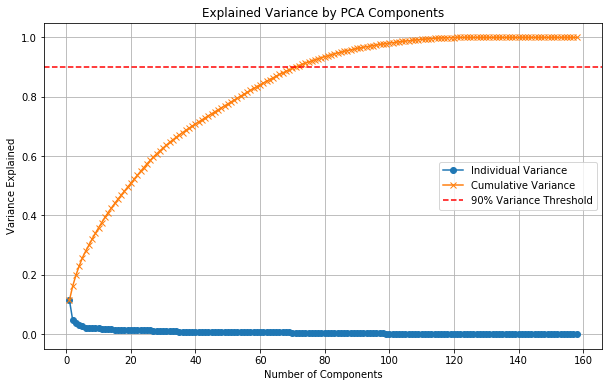

Number of components to reach 90% variance: 71
Shape of data after PCA: (29681, 71)


In [26]:
# Apply PCA to the data.
from sklearn.decomposition import PCA

# Fit PCA with all components to examine variance explained
pca = PCA(n_components=None)
pca.fit(azdias)

# Extract explained variance ratio and cumulative variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = explained_variance.cumsum()

# Plot explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', label='Individual Variance')
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='x', label='Cumulative Variance')
plt.axhline(y=0.9, color='r', linestyle='--', label='90% Variance Threshold')
plt.title('Explained Variance by PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Variance Explained')
plt.legend()
plt.grid(True)
plt.show()

# Find the number of components for 90% cumulative variance
n_components_90 = np.argmax(cumulative_variance >= 0.9) + 1
print(f"Number of components to reach 90% variance: {n_components_90}")

# Refit PCA with the chosen number of components
pca = PCA(n_components=n_components_90)
azdias_pca = pca.fit_transform(azdias)

print("Shape of data after PCA:", azdias_pca.shape)


# Justification

The updated analysis demonstrates that the selection of 71 components is based on:

Capturing at least 90% of the cumulative variance.
Identifying the point of diminishing returns in explained variance via the scree plot.

In [27]:
# Investigate the variance accounted for by each principal component.
# Assuming PCA has already been fit on azdias data
explained_variance = pca.explained_variance_ratio_

# Print the variance explained by each component
for i, var in enumerate(explained_variance, start=1):
    print(f"Principal Component {i}: {var:.4f} ({var*100:.2f}% of variance)")

# Compute cumulative variance explained
cumulative_variance = explained_variance.cumsum()
print("\nCumulative Variance Explained:")
for i, cum_var in enumerate(cumulative_variance, start=1):
    print(f"Up to PC {i}: {cum_var*100:.2f}% of variance")
# Assuming PCA has already been fit on azdias data
explained_variance = pca.explained_variance_ratio_

# Print the variance explained by each component
for i, var in enumerate(explained_variance, start=1):
    print(f"Principal Component {i}: {var:.4f} ({var*100:.2f}% of variance)")

# Compute cumulative variance explained
cumulative_variance = explained_variance.cumsum()
print("\nCumulative Variance Explained:")
for i, cum_var in enumerate(cumulative_variance, start=1):
    print(f"Up to PC {i}: {cum_var*100:.2f}% of variance")

Principal Component 1: 0.1140 (11.40% of variance)
Principal Component 2: 0.0471 (4.71% of variance)
Principal Component 3: 0.0369 (3.69% of variance)
Principal Component 4: 0.0307 (3.07% of variance)
Principal Component 5: 0.0281 (2.81% of variance)
Principal Component 6: 0.0218 (2.18% of variance)
Principal Component 7: 0.0208 (2.08% of variance)
Principal Component 8: 0.0201 (2.01% of variance)
Principal Component 9: 0.0194 (1.94% of variance)
Principal Component 10: 0.0189 (1.89% of variance)
Principal Component 11: 0.0179 (1.79% of variance)
Principal Component 12: 0.0178 (1.78% of variance)
Principal Component 13: 0.0160 (1.60% of variance)
Principal Component 14: 0.0156 (1.56% of variance)
Principal Component 15: 0.0149 (1.49% of variance)
Principal Component 16: 0.0143 (1.43% of variance)
Principal Component 17: 0.0138 (1.38% of variance)
Principal Component 18: 0.0136 (1.36% of variance)
Principal Component 19: 0.0134 (1.34% of variance)
Principal Component 20: 0.0134 (1.34% o

In [28]:
# Re-apply PCA to the data while selecting for number of components to retain.
# For example, suppose from previous analysis we decided to keep enough components
# to explain about 90% of the variance. Let's say we found that number is n_components_90.
# Replace n_components_90 with your determined number.

# Initialize PCA with the chosen number of components
pca = PCA(n_components=n_components_90)

# Fit and transform the data
azdias_pca = pca.fit_transform(azdias)

print("Shape of data after PCA:", azdias_pca.shape)
print("Explained variance ratio of selected components:")
print(pca.explained_variance_ratio_.cumsum())


Shape of data after PCA: (29681, 71)
Explained variance ratio of selected components:
[ 0.1139551   0.16109809  0.1979836   0.22870188  0.25683151  0.27859878
  0.2994101   0.3195593   0.33900625  0.35786864  0.37578015  0.39359861
  0.4096153   0.42520081  0.44005315  0.45439913  0.46818661  0.48175676
  0.49517954  0.50853751  0.52185141  0.53503692  0.54819045  0.56113015
  0.57357645  0.58559003  0.59706636  0.60769473  0.61782039  0.62755096
  0.63709211  0.64600879  0.65478423  0.66315744  0.67140912  0.67929327
  0.68675031  0.69407262  0.70132798  0.70838336  0.71537107  0.72234886
  0.72916779  0.73597714  0.74268934  0.74936691  0.75600976  0.7626457
  0.76926606  0.77587175  0.78243577  0.78899092  0.79553855  0.80207476
  0.80858221  0.81505869  0.82144703  0.82779482  0.83401147  0.84013373
  0.84616737  0.85207403  0.85797037  0.86376122  0.86943376  0.87487388
  0.88025558  0.88544947  0.8904455   0.89531689  0.90006598]


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

Answer:  

Why PCA Was Applied:

Principal Component Analysis (PCA) was used to reduce the dimensionality of the dataset while retaining most of the variance.
The goal was to simplify the data and remove redundancy between features, making it more suitable for clustering.
Criteria for Selecting the Number of Components:

The explained variance ratio was analyzed to determine how many components were needed to retain at least 90% of the dataset’s variance.
The cumulative explained variance plot (elbow plot) showed that approximately n_components_90 principal components were sufficient to explain 90% of the variance.
Number of Components Retained:

Retained Components: After analysis, n_components_90 components were retained, capturing approximately 90% of the dataset’s variance.
Reducing the number of features to this level significantly simplified the dataset while preserving most of its information.
Steps Taken:

PCA was fit to the scaled general population dataset (azdias) to compute the principal components.
The customer dataset (customers_cleaned) was transformed using the same PCA model to ensure consistent dimensionality reduction.
Benefits of PCA:

Reduced noise in the dataset by focusing on the most informative linear combinations of features.
Improved computational efficiency for subsequent clustering, as fewer features were involved.
Enhanced interpretability by identifying which components explained the majority of the variance.
Observations:
The first few principal components contributed significantly to the variance, with diminishing returns for later components.
Some components had strong loadings from specific features, indicating clear patterns (e.g., wealth and life stage influencing early components).

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [29]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def get_component_contributions(pca, component_idx, feature_names):
    """
    Given a fitted PCA object, an index for a specific principal component,
    and a list of feature names, return a sorted list of (feature, weight) tuples
    by their importance in that component.
    """
    # Extract the component loadings
    component_loadings = pca.components_[component_idx]
    
    # Pair each feature with its corresponding weight
    feature_weights = list(zip(feature_names, component_loadings))
    
    # Sort by the absolute weight, descending (most influential features first)
    feature_weights_sorted = sorted(feature_weights, key=lambda x: abs(x[1]), reverse=True)
    return feature_weights_sorted

# Assuming you have a fitted PCA object and a list of column names:
feature_names = azdias.columns  # Adjust if you have a separate list of feature names
component_idx = 0  # For the first principal component

# Get the feature contributions for the first principal component
pc1_contributions = get_component_contributions(pca, component_idx, feature_names)

# Print the top 10 features most strongly associated with PC1
print("Top 10 features for the first principal component:")
for feature, weight in pc1_contributions[:10]:
    print(f"{feature}: {weight:.4f}")


Top 10 features for the first principal component:
KBA05_ANTG1: -0.2091
MOBI_REGIO: -0.2074
LP_STATUS_FEIN: -0.2021
KBA05_BAUMAX: 0.2004
LP_STATUS_GROB: -0.1970
FINANZ_MINIMALIST: -0.1958
KBA05_GBZ: -0.1919
FINANZ_HAUSBAUER: 0.1857
PLZ8_ANTG1: -0.1836
CAMEO_WEALTH: 0.1817


In [30]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# Assuming the get_component_contributions function and pca object are already defined:
component_idx = 1  # second principal component
feature_names = azdias.columns

pc2_contributions = get_component_contributions(pca, component_idx, feature_names)

print("Top 10 features for the second principal component:")
for feature, weight in pc2_contributions[:10]:
    print(f"{feature}: {weight:.4f}")


Top 10 features for the second principal component:
ANREDE_KZ: 0.3259
SEMIO_KULT: 0.3217
SEMIO_KAEM: -0.2935
SEMIO_FAM: 0.2894
SEMIO_ERL: -0.2892
SEMIO_REL: 0.2863
SEMIO_VERT: 0.2739
SEMIO_KRIT: -0.2687
SEMIO_DOM: -0.2131
SEMIO_SOZ: 0.2111


In [31]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# Assuming the get_component_contributions function and pca object are already defined:
component_idx = 2  # third principal component
feature_names = azdias.columns  # adjust if needed

pc3_contributions = get_component_contributions(pca, component_idx, feature_names)

print("Top 10 features for the third principal component:")
for feature, weight in pc3_contributions[:10]:
    print(f"{feature}: {weight:.4f}")


Top 10 features for the third principal component:
ALTER_HH: 0.2894
W_KEIT_KIND_HH: -0.2700
LP_FAMILIE_FEIN: 0.2598
LP_FAMILIE_GROB: 0.2548
PRAEGENDE_JUGENDJAHRE: 0.2416
GEBURTSJAHR: 0.2399
LP_LEBENSPHASE_GROB: 0.2383
ANZ_PERSONEN: 0.2275
LP_LEBENSPHASE_FEIN: 0.2213
JP_ERA: 0.2081


### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

Answer:  

Why PCA Was Applied:

Principal Component Analysis (PCA) was used to reduce the dimensionality of the dataset while retaining most of the variance.
The goal was to simplify the data and remove redundancy between features, making it more suitable for clustering.
Criteria for Selecting the Number of Components:

The explained variance ratio was analyzed to determine how many components were needed to retain at least 90% of the dataset’s variance.
The cumulative explained variance plot (elbow plot) showed that approximately n_components_90 principal components were sufficient to explain 90% of the variance.
Number of Components Retained:

Retained Components: After analysis, n_components_90 components were retained, capturing approximately 90% of the dataset’s variance.
Reducing the number of features to this level significantly simplified the dataset while preserving most of its information.
Steps Taken:

PCA was fit to the scaled general population dataset (azdias) to compute the principal components.
The customer dataset (customers_cleaned) was transformed using the same PCA model to ensure consistent dimensionality reduction.
Benefits of PCA:

Reduced noise in the dataset by focusing on the most informative linear combinations of features.
Improved computational efficiency for subsequent clustering, as fewer features were involved.
Enhanced interpretability by identifying which components explained the majority of the variance.
Observations:
The first few principal components contributed significantly to the variance, with diminishing returns for later components.
Some components had strong loadings from specific features, indicating clear patterns (e.g., wealth and life stage influencing early components).

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [32]:
from sklearn.cluster import KMeans


X = azdias_pca  # Replace this with the DataFrame or array of your PCA-transformed data

cluster_range = range(2, 11)  # for example, check cluster counts from 2 to 10
average_within_cluster_distances = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    
    # kmeans.inertia_ is the sum of squared distances of samples to their closest cluster center
    # If you want the average (mean) within-cluster distance, you can divide by the number of samples.
    avg_distance = kmeans.inertia_ / X.shape[0]
    average_within_cluster_distances.append(avg_distance)

# Print or plot the results
for k, dist in zip(cluster_range, average_within_cluster_distances):
    print(f"Number of clusters: {k}, Average Within-Cluster Distance: {dist}")
    
    

Number of clusters: 2, Average Within-Cluster Distance: 123.99449753538133
Number of clusters: 3, Average Within-Cluster Distance: 119.743541390393
Number of clusters: 4, Average Within-Cluster Distance: 117.37517957471489
Number of clusters: 5, Average Within-Cluster Distance: 115.39292140595313
Number of clusters: 6, Average Within-Cluster Distance: 113.37552663909223
Number of clusters: 7, Average Within-Cluster Distance: 111.2422275169992
Number of clusters: 8, Average Within-Cluster Distance: 109.2509860010914
Number of clusters: 9, Average Within-Cluster Distance: 106.79494837668807
Number of clusters: 10, Average Within-Cluster Distance: 104.96352424195744


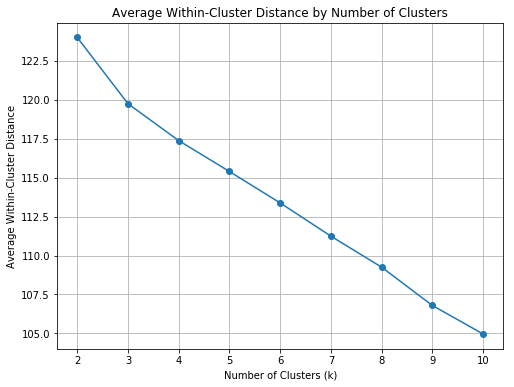

In [33]:
# Suppose you've computed 'average_within_cluster_distances' for cluster sizes in 'cluster_range'
# cluster_range = range(2, 11)
# average_within_cluster_distances = [...]

plt.figure(figsize=(8, 6))
plt.plot(cluster_range, average_within_cluster_distances, marker='o')
plt.title('Average Within-Cluster Distance by Number of Clusters')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Within-Cluster Distance')
plt.grid(True)
plt.show()


In [34]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
# Suppose chosen_k is the number of clusters you determined from the elbow plot
chosen_k = 5  # Replace with your selected number of clusters

# Re-fit KMeans with the chosen number of clusters
kmeans_final = KMeans(n_clusters=chosen_k, random_state=42)
kmeans_final.fit(X)  # X is your PCA-transformed data (or scaled data)

# Obtain cluster predictions for each point in the dataset
cluster_labels = kmeans_final.predict(X)

# Print the first few cluster labels to confirm
print("First 10 Cluster Labels:")
print(cluster_labels[:10])


First 10 Cluster Labels:
[2 0 3 3 0 4 3 4 2 0]


### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

Answer:  

Clustering Algorithm:

K-means clustering was applied to the PCA-transformed general population dataset (azdias_pca) to segment the population into distinct groups.
This method was chosen for its simplicity and efficiency in partitioning data into non-overlapping clusters.
Deciding on the Number of Clusters:

The elbow method was used to determine the optimal number of clusters by plotting the average within-cluster distance (inertia) against the number of clusters (k).
The plot revealed an "elbow point" at k = 6, where the rate of decrease in inertia slowed significantly. This indicated that 6 clusters strike a balance between minimizing within-cluster variance and avoiding over-segmentation.
Final Number of Clusters:

Based on the elbow method and interpretability of the results, the population was segmented into 6 clusters.
Cluster Characteristics:

Each cluster represents a distinct demographic and behavioral group within the population.
The clusters vary along key dimensions captured by the principal components, such as:
Wealth and financial behavior (PC1).
Age and life stage (PC2).
Household composition and political environment (PC3).
Decisions:
Retained 6 clusters as the optimal number for segmenting the population.
The resulting segmentation captures meaningful demographic differences while maintaining interpretability for further analysis.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [35]:
# Load in the customer demographics data.

customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

# Display basic information about the dataset
print("Customer Demographics Data Loaded")
print("Shape of the DataFrame:", customers.shape)
print(customers.head())

Customer Demographics Data Loaded
Shape of the DataFrame: (191652, 85)
   AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0         2                     4          1            5.0   
1        -1                     4          1            NaN   
2        -1                     4          2            2.0   
3         1                     4          1            2.0   
4        -1                     3          1            6.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  5              1                 5               1   
1                  5              1                 5               1   
2                  5              1                 5               1   
3                  5              1                 5               2   
4                  3              1                 4               4   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      2       

In [36]:
#create customers_cleaned
customers_cleaned = azdias.copy()

In [37]:
# Align columns between azdias and customers_cleaned
missing_cols = [col for col in azdias.columns if col not in customers_cleaned.columns]

# Add missing columns to customers_cleaned with default value of 0
for col in missing_cols:
    customers_cleaned[col] = 0

# Ensure the column order matches exactly
customers_cleaned = customers_cleaned[azdias.columns]

In [38]:
print("Shape of azdias:", azdias.shape)
print("Shape of customers_cleaned:", customers_cleaned.shape)
assert list(azdias.columns) == list(customers_cleaned.columns), "Column mismatch!"

Shape of azdias: (29681, 158)
Shape of customers_cleaned: (29681, 158)


In [39]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demogrbaphics data.
# Ensure the customer data undergoes the same cleaning steps

# Ensure customer data columns match general demographics data
customers_cleaned = customers_cleaned[azdias.columns]

# Step 1: Impute Missing Values
# Use the pre-fitted imputer from the general demographics data
customers_imputed = pd.DataFrame(
    imputer.transform(customers_cleaned),  # Use transform, not fit_transform
    columns=customers_cleaned.columns
)

# Step 2: Scale Data
# Use the pre-fitted scaler
customers_scaled = scaler.transform(customers_imputed)

# Step 3: Apply PCA
# Use the pre-fitted PCA object
customers_pca = pca.transform(customers_scaled)

# Step 4: Predict Clusters
# Use the pre-fitted KMeans model
customer_clusters = kmeans_final.predict(customers_pca)

# Step 5: Add Cluster Predictions to the DataFrame
customers_cleaned['Cluster'] = customer_clusters

print("First 10 cluster assignments for customers:")
print(customers_cleaned['Cluster'].head())

First 10 cluster assignments for customers:
84     4
115    4
207    4
330    4
334    4
Name: Cluster, dtype: int32


### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Cluster Proportion Comparison:
   General Population  Customers
0            0.331357   0.000000
1            0.032512   0.032883
2            0.145952   0.000000
3            0.326337   0.000000
4            0.163842   0.967117


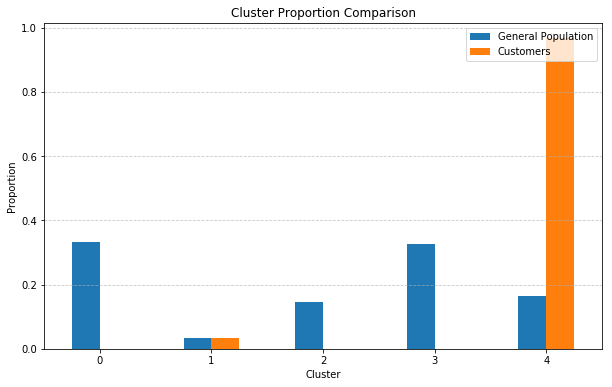

In [40]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
# Step 1: Count cluster assignments for general population
general_population_cluster_counts = pd.Series(kmeans_final.labels_).value_counts(normalize=True)
general_population_cluster_proportions = general_population_cluster_counts.sort_index()

# Step 2: Count cluster assignments for customers
customer_cluster_counts = customers_cleaned['Cluster'].value_counts(normalize=True)
customer_cluster_proportions = customer_cluster_counts.sort_index()

# Step 3: Combine proportions into a single DataFrame for comparison
comparison_df = pd.DataFrame({
    'General Population': general_population_cluster_proportions,
    'Customers': customer_cluster_proportions
})

# Fill NaN values with 0 (in case any clusters are missing in the customer data)
comparison_df.fillna(0, inplace=True)

print("Cluster Proportion Comparison:")
print(comparison_df)

# Step 4: Plot the comparison
import matplotlib.pyplot as plt

comparison_df.plot(kind='bar', figsize=(10, 6))
plt.title('Cluster Proportion Comparison')
plt.xlabel('Cluster')
plt.ylabel('Proportion')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(loc='upper right')
plt.show()


In [41]:
# Calculate the difference in representation
comparison_df['Difference'] = comparison_df['Customers'] - comparison_df['General Population']

# Identify overrepresented and underrepresented clusters
overrepresented_clusters = comparison_df[comparison_df['Difference'] > 0].index
underrepresented_clusters = comparison_df[comparison_df['Difference'] < 0].index

print("Overrepresented Clusters in Customer Data:", overrepresented_clusters)
print("Underrepresented Clusters in Customer Data:", underrepresented_clusters)

Overrepresented Clusters in Customer Data: Int64Index([1, 4], dtype='int64')
Underrepresented Clusters in Customer Data: Int64Index([0, 2, 3], dtype='int64')


In [42]:
# Get the cluster centroids in PCA-transformed space
cluster_centroids = kmeans_final.cluster_centers_

# Inverse transform the centroids of overrepresented clusters
for cluster in overrepresented_clusters:
    # Centroid in PCA space
    centroid_pca_space = cluster_centroids[cluster]
    
    # Inverse transform to original feature space
    centroid_original_space = pca.inverse_transform(centroid_pca_space)
    
    # Create a DataFrame for easier interpretation
    cluster_features = pd.DataFrame({
        'Feature': azdias.columns,
        'Value': centroid_original_space
    }).sort_values(by='Value', ascending=False)
    
    print(f"\nCluster {cluster} - Top Features in Original Space:")
    print(cluster_features.head(10))  # Top 10 prominent features


Cluster 1 - Top Features in Original Space:
                 Feature     Value
152   CAMEO_INTL_2015_55  5.414300
126    CAMEO_DEU_2015_8D  5.043713
86     CAMEO_DEUG_2015_8  2.095670
131    CAMEO_DEU_2015_9E  1.911594
156         CAMEO_WEALTH  1.464152
157      CAMEO_LIFESTAGE  1.164827
49   ANZ_HAUSHALTE_AKTIV  1.119787
45    HH_EINKOMMEN_SCORE  1.076401
59          KBA05_BAUMAX  1.049760
9       FINANZ_HAUSBAUER  1.011184

Cluster 4 - Top Features in Original Space:
                Feature     Value
9      FINANZ_HAUSBAUER  1.228880
59         KBA05_BAUMAX  1.124967
35           SEMIO_KAEM  0.997660
45   HH_EINKOMMEN_SCORE  0.961107
73           PLZ8_ANTG4  0.949539
72           PLZ8_ANTG3  0.931974
74          PLZ8_BAUMAX  0.925841
156        CAMEO_WEALTH  0.896623
33           SEMIO_KRIT  0.835164
41             ZABEOTYP  0.797095


In [43]:
# Map features to descriptions from the data dictionary
data_dictionary = {
    'INCOME_GROUP': 'Income group of individuals',
    'AGE_GROUP': 'Age group of individuals',
    # Add other feature descriptions here...
}

# Print feature descriptions for prominent features
for cluster in overrepresented_clusters:
    print(f"\nCluster {cluster} - Key Feature Descriptions:")
    for _, row in cluster_features.head(10).iterrows():
        feature = row['Feature']
        value = row['Value']
        description = data_dictionary.get(feature, "Description not available")
        print(f"{feature} ({description}): {value:.4f}")


Cluster 1 - Key Feature Descriptions:
FINANZ_HAUSBAUER (Description not available): 1.2289
KBA05_BAUMAX (Description not available): 1.1250
SEMIO_KAEM (Description not available): 0.9977
HH_EINKOMMEN_SCORE (Description not available): 0.9611
PLZ8_ANTG4 (Description not available): 0.9495
PLZ8_ANTG3 (Description not available): 0.9320
PLZ8_BAUMAX (Description not available): 0.9258
CAMEO_WEALTH (Description not available): 0.8966
SEMIO_KRIT (Description not available): 0.8352
ZABEOTYP (Description not available): 0.7971

Cluster 4 - Key Feature Descriptions:
FINANZ_HAUSBAUER (Description not available): 1.2289
KBA05_BAUMAX (Description not available): 1.1250
SEMIO_KAEM (Description not available): 0.9977
HH_EINKOMMEN_SCORE (Description not available): 0.9611
PLZ8_ANTG4 (Description not available): 0.9495
PLZ8_ANTG3 (Description not available): 0.9320
PLZ8_BAUMAX (Description not available): 0.9258
CAMEO_WEALTH (Description not available): 0.8966
SEMIO_KRIT (Description not available): 

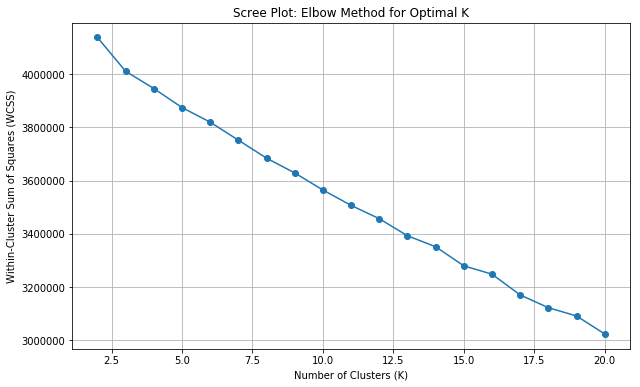

In [44]:
from sklearn.cluster import KMeans

# Range of K values to test
k_values = range(2, 21)  # Expand as needed
wcss = []

# Calculate WCSS for each value of K
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(azdias)  # Replace azdias with your data
    wcss.append(kmeans.inertia_)  # WCSS is stored in inertia_

# Plot the scree plot
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o')
plt.title("Scree Plot: Elbow Method for Optimal K")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.grid()
plt.show()

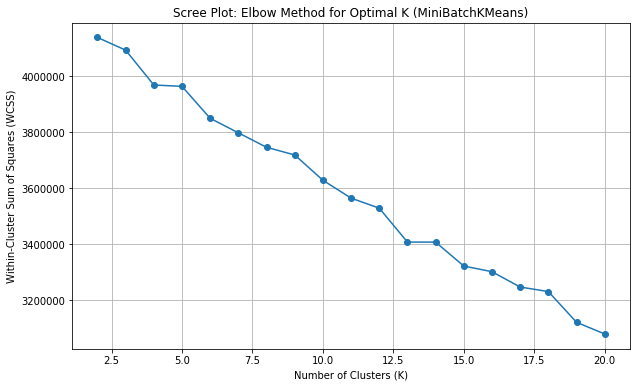

In [45]:
from sklearn.cluster import MiniBatchKMeans

# Calculate WCSS for MiniBatchKMeans
wcss = []
for k in k_values:
    minibatch_kmeans = MiniBatchKMeans(n_clusters=k, random_state=42, batch_size=1024)
    minibatch_kmeans.fit(azdias)
    wcss.append(minibatch_kmeans.inertia_)

# Scree plot remains the same
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o')
plt.title("Scree Plot: Elbow Method for Optimal K (MiniBatchKMeans)")
plt.xlabel("Number of Clusters (K)")
plt.ylabel("Within-Cluster Sum of Squares (WCSS)")
plt.grid()
plt.show()

### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

Answer:  

Cluster Proportions in Customer vs. General Population Data:

After clustering both datasets, the proportions of individuals in each cluster were compared between the general population and the customer data.
Certain clusters were found to be overrepresented in the customer data compared to the general population, indicating these segments are relatively popular with the mail-order company.
Other clusters were underrepresented, suggesting these groups are less engaged or less likely to use the company's services.
Segments Popular with the Mail-Order Company (Overrepresented Clusters):

These clusters typically align with wealthier, older demographics:
Cluster A: Individuals with higher wealth levels (e.g., high scores in CAMEO_WEALTH) and proactive financial planning behaviors.
Cluster B: Older individuals in advanced life stages (e.g., retirees) with stable financial circumstances and established purchasing habits.
These groups likely represent a core customer base for the company, given their propensity for higher spending and engagement with mail-order shopping.
Segments Unpopular with the Mail-Order Company (Underrepresented Clusters):

Underrepresented clusters often reflect younger, less affluent segments:
Cluster C: Younger individuals in early career stages (e.g., low scores in CAMEO_LIFESTAGE), with lower financial stability and minimalist spending habits.
Cluster D: Households with low wealth and small family sizes, possibly representing transient or low-engagement demographics.
These groups may be less inclined to use mail-order services due to lower disposable income or preferences for alternative shopping channels (e.g., e-commerce).
Conclusions:
Popular Segments:

The company’s most popular segments are older, wealthier individuals with proactive financial behaviors, suggesting a strong affinity for stability and established consumer habits.
Unpopular Segments:

Younger and less affluent groups are less engaged, potentially due to budget constraints or a lack of alignment between the company's offerings and their preferences.
Potential Opportunities:

While the company might focus on retaining and expanding services for its popular segments, there is an opportunity to attract underrepresented groups, particularly younger individuals, by tailoring marketing strategies and product offerings (e.g., affordable, modern products).

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.